In [3]:
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# System parameters
m = 1.0    # mass
c = 0.5    # damping coefficient
k = 4.0    # spring constant


In [5]:
# Define the ODE system
def oscillator(t, y):
    x, v = y
    dxdt = v
    dvdt = -(c/m)*v - (k/m)*x
    return [dxdt, dvdt]

In [6]:
# Simulate multiple initial conditions
def simulate_oscillator(x0, v0, t_span=(0, 10), t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 100)
    sol = solve_ivp(oscillator, t_span, [x0, v0], t_eval=t_eval)
    return sol.t, sol.y[0]

In [7]:
# Generate dataset
data = []
for _ in range(500):
    x0 = np.random.uniform(-10, 10)
    v0 = np.random.uniform(-5, 5)
    t, x = simulate_oscillator(x0, v0)
    features = [x0, v0]
    target = x[-1]  # final displacement
    data.append(features + [target])

In [8]:
df = pd.DataFrame(data, columns=["x0", "v0", "x_final"])
df.to_csv("oscillator_dataset.csv", index=False)

In [9]:
df.head()

,x0,v0,x_final
0,3.882473,-0.875248,0.175669
1,-5.493475,1.778244,-0.229905
2,7.767367,-4.714758,0.249077
3,4.870552,4.729455,0.422028
4,-0.753340,3.578502,0.083839


In [10]:
df.isnull().sum()

x0         0
v0         0
x_final    0
dtype: int64

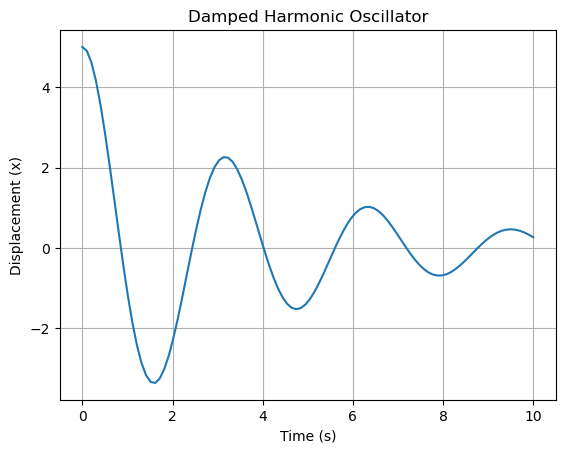

In [11]:
import matplotlib.pyplot as plt
import numpy as np

t, x = simulate_oscillator(x0=5, v0=0)

plt.plot(t, x)
plt.title("Damped Harmonic Oscillator")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (x)")
plt.grid(True)
plt.show()

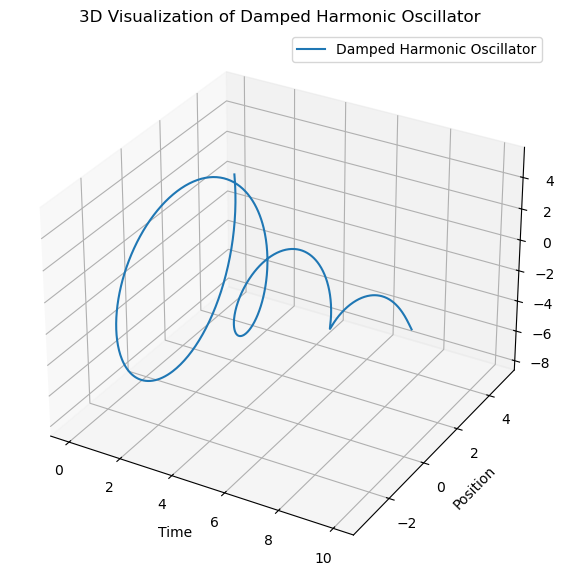

In [12]:
t_span = (0, 10)
y0 = [5, 0]  # initial position 5, initial velocity 0
t_eval = np.linspace(*t_span, 1000)

# Solve ODE
sol = solve_ivp(oscillator, t_span, y0, t_eval=t_eval)

# Extract results
t = sol.t
x = sol.y[0]
v = sol.y[1]

# Plotting 3D trajectory: time vs position vs velocity
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(t, x, v, label='Damped Harmonic Oscillator')
ax.set_xlabel('Time')
ax.set_ylabel('Position')
ax.set_zlabel('Velocity')
ax.set_title('3D Visualization of Damped Harmonic Oscillator')
ax.legend()

plt.show()

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

In [14]:
# Remove last value from x, v to use as input
X = np.column_stack((x[:-1], v[:-1]))  # Features at time t

# Target: x at next time step (t + Δt)
y = x[1:]  # Shifted one step forward

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train MLP
model = MLPRegressor(hidden_layer_sizes=(64, 64), activation='tanh', max_iter=5000)
model.fit(X_train, y_train)

# Evaluate
score = model.score(X_test, y_test)
print("Test R² Score:", score)

Test R² Score: 0.9979185281574487


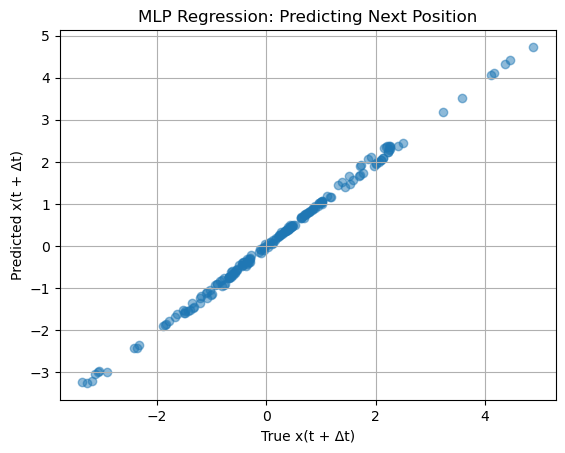

In [16]:
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True x(t + Δt)")
plt.ylabel("Predicted x(t + Δt)")
plt.title("MLP Regression: Predicting Next Position")
plt.grid(True)
plt.show()

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R² Score:", r2_score(y_test, y_pred_lr))

# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree R² Score:", r2_score(y_test, y_pred_dt))

Linear Regression R² Score: 0.9999999997190564
Decision Tree R² Score: 0.9993754383638439


In [18]:
noise_std = 0.5  # You can try 0.1, 0.5, 1.0 later
X_train_noisy = X_train + np.random.normal(0, noise_std, X_train.shape)
X_test_noisy = X_test + np.random.normal(0, noise_std, X_test.shape)
y_train_noisy = y_train + np.random.normal(0, noise_std, y_train.shape)

# --- MLP ---
mlp = MLPRegressor(hidden_layer_sizes=(64, 64), activation='tanh', max_iter=5000)
mlp.fit(X_train_noisy, y_train)
y_pred_mlp = mlp.predict(X_test_noisy)
r2_mlp = r2_score(y_test, y_pred_mlp)
print("MLP (Noisy X) R² Score:", r2_mlp)

# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train_noisy, y_train)
y_pred_lr = lr.predict(X_test_noisy)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression (Noisy X) R² Score:", r2_lr)

# --- Decision Tree ---
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_noisy, y_train)
y_pred_dt = dt.predict(X_test_noisy)
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree (Noisy X) R² Score:", r2_dt)

MLP (Noisy X) R² Score: 0.9071534477243891
Linear Regression (Noisy X) R² Score: 0.9057644499014716
Decision Tree (Noisy X) R² Score: 0.8095464203396805


In [19]:
import joblib

# Save
joblib.dump(model, 'harmonic_surrogate_model.pkl')

# Load later
# model = joblib.load('harmonic_surrogate_model.pkl')

['harmonic_surrogate_model.pkl']

In [40]:
# predict.py
import joblib
import numpy as np

model = joblib.load('harmonic_surrogate_model.pkl')

def predict(position, velocity):
    X = np.array([[position, velocity]])
    return model.predict(X)[0]

# Example usage
if __name__ == "__main__":
    pos = 1.0
    vel = 0.5
    pred = predict(pos, vel)
    print("Predicted position:", pred)

Predicted position: 1.0414262426888679
